In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize 
import gensim
import gensim.downloader as api
import string
import re
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords 
from fuzzywuzzy import fuzz
from sklearn import preprocessing
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec, KeyedVectors
from scipy.cluster import  hierarchy

## Load pretrained Word2Vec and sample data

In [ ]:
#model = api.load("word2vec-google-news-300")

In [2]:
model_path = api.load("word2vec-google-news-300", return_path=True)

In [58]:
w2v = KeyedVectors.load_word2vec_format(model_path, binary= True)

In [59]:
# normalized model so we can use wmdistance later
w2v_norm = KeyedVectors.load_word2vec_format(model_path, binary= True)
w2v_norm.init_sims(replace=True)

In [9]:
with open('../data/data.txt', 'r') as f: 
    data = f.readlines()
f.close()
data = [x.rstrip().lstrip().strip('\",') for x in data]

In [10]:
print (data)

['Marks and Spencers Ltd', 'M&S Limited', 'NVIDIA Ireland', 'SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'LONDON', 'HONG KONG', 'ASIA', 'JP Morgan & Chase Co.', 'ICNAO02312', 'TOYS', '5 Time Square, New York, NY 10036', 'COMPUTER PARTS', 'INTEL CORPORATION', 'INTEL CO', 'Ryland Group Inc.', 'Sabre Holdings Corp', 'Safeco Corp', '4CE0460D0G', 'Vero Beach, Florida', 'WINE', 'Microwave', 'Plastic container', 'Europe', 'Canada', 'HGU6UH3']


## Preprocess data

In [473]:
df = pd.DataFrame()
df['text'] = data

In [474]:
table = str.maketrans('', '', string.punctuation.replace('#', '').replace('&', ''))
stop_words = set(stopwords.words('english')) 
    # After trying different preprocessing combinations, I decided not to filter out stops words, 
    # and keept '#' and '&' since they can help defining a string in our specific case 
def get_tokens(x): 
    x = re.sub(r'\d', '#', x).lower()
    tokens = word_tokenize(x)
    tokens = [w.translate(table) for w in tokens]
    tokens = [x for x in tokens if x != '']
    return tokens

In [475]:
df['clean_token'] = df['text'].apply(lambda x: get_tokens(x))

## Get word2vec vectors from pretrained model

In [25]:
model_vocab = w2v.vocab

In [476]:
# get vector per string
def get_vector(x):
    agg_vector = []
    for token in x: 
        if token in model_vocab: 
            v = w2v[token]  
        elif token.capitalize() in model_vocab:
            v = w2v[token.capitalize()] 
        else: 
            print (token, 'NOT FOUND!')
            v = w2v['#'] # assign unknown words (usually random letters in a serial number) to # to skew the vector
        agg_vector.append(v)
    agg_vector = np.array(agg_vector)
    agg_vector = np.mean(agg_vector, axis = 0)
    return agg_vector

In [477]:
df['vecter_300'] = df['clean_token'].apply(lambda x: get_vector(x))

abcicl NOT FOUND!
icnao NOT FOUND!
hgu NOT FOUND!


## Add more features

In [481]:
# Adding word and character count, and a flag for possible company name
company_str = ['corporation', 'inc', 'co', 'corp', 'cooperatives', 'ltd', 'limited', 'company', \
               'lp', 'incorporated', 'international']

def get_word_cnt(x): 
    return len(x)

def get_char_cnt(x): 
    return len(''.join(x))

def get_company_flag(x): 
    if any(w in company_str for w in x): 
        return 1
    else: return 0 
        
df['word_count'] = df['clean_token'].apply(lambda x: get_word_cnt(x))
df['char_count'] = df['clean_token'].apply(lambda x: get_char_cnt(x))
df['company_str'] = df['clean_token'].apply(lambda x: get_company_flag(x))

In [482]:
def concat_features(row): 
    concat_list = np.array([row['word_count'], row['char_count'], row['company_str']])
    new_concat_list = np.append(row['vecter_300'], concat_list)
    return new_concat_list

In [483]:
df['new_feature_concat'] = df.apply(lambda row: concat_features(row), axis = 1)

In [485]:
df.head(3)

,text,clean_token,vecter_300,word_count,char_count,company_str,new_feature_concat
0,Marks and Spencers Ltd,"[marks, and, spencers, ltd]","[-0.081870556, -0.028320312, -0.05102539, 0.10...",4,19,1,"[-0.08187055587768555, -0.0283203125, -0.05102..."
1,M&S Limited,"[m, &, s, limited]","[-0.15039062, 0.09075928, -0.11743164, 0.13623...",4,10,1,"[-0.150390625, 0.09075927734375, -0.1174316406..."
2,NVIDIA Ireland,"[nvidia, ireland]","[0.01928711, -0.19091797, -0.053955078, 0.3242...",2,13,0,"[0.019287109375, -0.19091796875, -0.0539550781..."


## Normalize matrix

In [318]:
def scale_mat(vec_matrix,preprocess_type):
    if preprocess_type == 'MinMax':
        scale = preprocessing.MinMaxScaler().fit(vec_matrix)  
    if preprocess_type == 'Standard':
        scale = preprocessing.StandardScaler().fit(vec_matrix)
    vals = scale.transform(vec_matrix)
    return vals

vector_matrix = np.array(df['new_feature_concat'].tolist())
vector_matrix = scale_mat(vector_matrix, 'MinMax')
print ('vector size: ', vector_matrix.shape)

vector size:  (31, 303)


In [171]:
# PCA reduce dimensions
sklearn_pca = PCA(n_components = 2)
vals_pca = sklearn_pca.fit_transform(vector_matrix)

In [319]:
# Add 2D array to df 
df['2D'] = vals_pca.tolist()

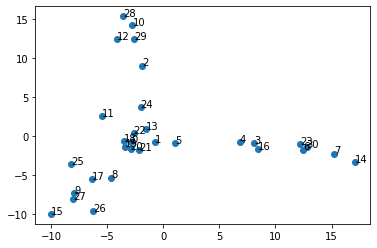

In [320]:
# plot
data2D = np.array(df['2D'].tolist())
n = df.index
plt.scatter(vals_pca[:,0], vals_pca[:,1])
for i, txt in enumerate(n):
    plt.annotate(txt, (vals_pca[i,0], vals_pca[i,1]))
plt.show()

We can see that there are some sort of patterns forming. Some examples are: 
<br> On top there are locations: 10(LONDON), 12(ASIA), 28(Europ), and 29(Canada) 
<br> The center cluster is mostly companies: 0(Marks and Spencers Ltd), 1(M&S Limited), 21(Sabre Holdings Corp), 13(JP Morgan & Chase Co)
<br> Bottom left is mostly items, there are 8(HARDWOOD TABLE), 9(PLASTIC BOTTLE), 15(TOYS), 17(COMPUTER PARTS), 25(WINE), 26(microwave), 27(Plastic container)
<br> On the far right, there are serial numbers: 6(XYZ 13423 / ILD), 7(ABC/ICL/20891NC), 14(ICNAO02312), 23(4CE0460D0G), 30(HGU6UH3)

## Curious to see the clusters in a more mathematical way
<b> (Though hierarchy can't really be applied to massive data)

In [195]:
def print_clusters(df, cluster_col):
    cluster_dict = df.groupby(cluster_col)['text'].apply(list).to_dict()
    for k, v, in cluster_dict.items():
        print (k, v)
        print ()

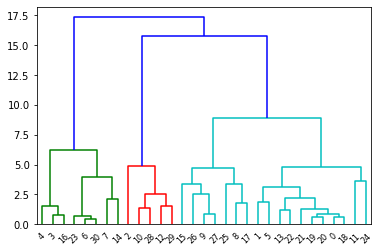

In [328]:
Z = hierarchy.linkage(vals_pca, method = "average", metric = 'euclidean')
plt.figure()
dn = hierarchy.dendrogram(Z)

Decent hierarchy graph, looks like 5 would be a good threshold

In [313]:
threshold = 5
C = hierarchy.fcluster(Z, threshold, criterion="distance")
labels = (C).tolist()
labels = ['cluster_'+str(s) for s in labels]

In [322]:
df['eps=0.3'] = labels
print_clusters(df, 'eps=0.3')

cluster_1 ['SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', '5 Time Square, New York, NY 10036']

cluster_2 ['XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'ICNAO02312', '4CE0460D0G', 'HGU6UH3']

cluster_3 ['NVIDIA Ireland', 'LONDON', 'ASIA', 'Europe', 'Canada']

cluster_4 ['HARDWOOD TABLE', 'PLASTIC BOTTLE', 'TOYS', 'COMPUTER PARTS', 'WINE', 'Microwave', 'Plastic container']

cluster_5 ['Marks and Spencers Ltd', 'M&S Limited', '44 CHINA ROAD, KOWLOON, HONG KONG', 'HONG KONG', 'JP Morgan & Chase Co.', 'INTEL CORPORATION', 'INTEL CO', 'Ryland Group Inc.', 'Sabre Holdings Corp', 'Safeco Corp', 'Vero Beach, Florida']



## Add features for unique entity recognition 

In [ ]:
import scipy.spatial.distance as D

In [497]:
# Warp - Preprocess, get vector features, and normalize 
def get_feature_vector_303(string_input): 
    token = get_tokens(string_input)
    word_vec_google = get_vector(token)
    word_cnt = get_word_cnt(token)
    char_cnt = get_char_cnt(token)
    com_flag = get_company_flag(token)
    extra_features = np.array([word_cnt, char_cnt, com_flag])
    v = np.append(word_vec_google, extra_features)
    #v = scale_mat(v.reshape(-1,1),'MinMax')
    return token, word_cnt, char_cnt, com_flag, v

In [517]:
def scaler_for_df(df): 
    df_array = np.array(df['vec_303'])[0]
    return df_array

In [520]:
# Start with 'HARDWOOD TABLE'
init_string = 'HARDWOOD TABLE'
init_run = get_feature_vector_303(init_string)
my_df = pd.DataFrame({'text': [init_string], 'clean_string': [' '.join(init_run[0])], \
                      'clean_token': [init_run[0]], 'word_cnt':[init_run[1]], \
                      'char_cnt':[init_run[2]], 'com_flag': [init_run[3]],\
                      'vec_303': [init_run[4]], 'vec_303_norm': ''})
#my_df.iloc[0,7] = [scaler_for_df(my_df)]

In [521]:
my_df

,text,clean_string,clean_token,word_cnt,char_cnt,com_flag,vec_303,vec_303_norm
0,HARDWOOD TABLE,hardwood table,"[hardwood, table]",2,13,0,"[-0.066802978515625, 0.09027099609375, 0.01513...",


In [499]:
test_string = 'apple computer'
test_ = get_feature_vector_303(test_string)
test_token = test_[0]
test_clean_string = ' '.join(test_[0])
test_w_cnt = test_[1]
test_c_cnt = test_[2]
test_vector = test_[4]

In [500]:
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df['fuzz_token_sort_ratio']

2

In [513]:
for idx, row in my_df.iterrows(): 
    my_dict = row.to_dict()
    character_list = []
    character_list.append(my_dict['word_cnt']-test_w_cnt) # word count difference
    character_list.append(my_dict['char_cnt']-test_c_cnt) # character count difference
    character_list.append(len(set(my_dict['clean_token']).intersection(set(test_token)))) # number of common word
    character_list.append(fuzz.ratio(my_dict['clean_string'], test_clean_string)) # fuzz ratio
    character_list.append(fuzz.partial_ratio(my_dict['clean_string'], test_clean_string)) # fuzz partical
    character_list.append(fuzz.token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.token_sort_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_sort_ratio(my_dict['clean_string'], test_clean_string))
    print (character_list)
    print (get_all_dist())

[0, 0, 0, 29, 29, 29, 29, 29, 29]


In [515]:
# return a matrix of all kinds of distances 
def get_all_dist(v1, v2): 
    dist_list = []
    dist_list.append(D.cosine(v1, v2))
    dist_list.append(D.euclidean((v1, v2)))
    return np.array(dist_list)

In [467]:
get_all_dist()

{'text': 'HARDWOOD TABLE', 'clean_string': 'hardwood table', 'clean_token': ['hardwood', 'table'], 'word_cnt': 2, 'char_cnt': 13, 'com_flag': 0, 'vec_303': array([-6.68029785e-02,  9.02709961e-02,  1.51367188e-02,  2.20703125e-01,
        1.40014648e-01, -5.60302734e-02,  7.73925781e-02, -3.54003906e-01,
        1.87255859e-01,  3.33007812e-01, -7.11669922e-02, -2.16308594e-01,
        2.08496094e-01, -2.07519531e-02,  1.04980469e-02,  9.16748047e-02,
       -3.02734375e-02,  5.01708984e-02,  1.87988281e-01,  2.22167969e-01,
        1.85546875e-02,  1.02294922e-01, -2.44140625e-02,  3.34472656e-02,
       -7.73925781e-02,  1.28417969e-01, -1.58203125e-01,  1.08032227e-01,
       -1.14501953e-01, -1.08398438e-01, -1.46484375e-02,  5.45654297e-02,
        5.23834229e-02,  9.52148438e-02, -6.26220703e-02, -9.57031250e-02,
       -1.33056641e-01, -2.63671875e-02,  4.73632812e-02,  3.56445312e-02,
        3.58886719e-02, -2.67089844e-01,  6.44531250e-02, -1.16943359e-01,
        1.61621094e

In [403]:
get_cosine_dist(init_vector, test_vector)

(303, 1)


0.018331223903671368

In [333]:

a = df.iloc[0,3]
b = df.iloc[1,3]
cos_sim = dot(a, b)/(norm(a)*norm(b))

In [334]:
cos_sim

0.8627565141838561

In [ ]:
df.iloc[2,0]

In [ ]:
from scipy import spatial

result = 1-spatial.distance.cosine(a, b)

In [ ]:
print (w2v.distance('corporation', 'co'))
print (w2v.wmdistance('corporation', 'co'))
print (w2v_norm.distance('corporation', 'co'))
print (w2v_norm.wmdistance('corporation', 'co'))
'''
def compute_similarity(s1, s2):
    return 1.0 - (0.01 * max(fuzz.ratio(s1, s2),fuzz.token_sort_ratio(s1, s2),fuzz.token_set_ratio(s1, s2)))
compute_similarity('INTELCORPORATION', 'INTELCO')
'''

In [ ]:
# add distance 
def get_distance(v1, v2): 
    return w2v.distance(a, b)

# add Word Mover's Distance
def get_WMD(v1, v2): 
    return w2v_norm.wmdistance(a, b)

def get_word_delta(tokens_1, tokens_2): 
    return 

In [ ]:
def dist_metric(a, b):
    sim = np.isnan(dot(a, b)/(norm(a)*norm(b)))
    if sim == False:
        return dot(a, b)/(norm(a)*norm(b))